# Linear Regression

*Adapted from Chapter 3 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

# Part 1: Introduction

- **Classification problem:** supervised learning problem with a categorical response
- **Regression problem**: supervised learning problem with a continuous response
- **Linear regression:** machine learning model that can be used for regression problems

Why are we learning linear regression?

- widely used
- runs fast
- easy to use (no tuning is required)
- highly interpretable
- basis for many other methods

Lesson goals:

- Conceptual understanding of linear regression and how it "works"
- Familiarity with key terminology
- Ability to apply linear regression to a machine learning problem using scikit-learn
- Ability to interpret model coefficients
- Familiarity with different approaches for feature selection
- Understanding of three different evaluation metrics for regression
- Understanding of linear regression's strengths and weaknesses

## Libraries

- [scikit-learn](http://scikit-learn.org/stable/): "machine learning in Python"

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Reading the advertising data

In [2]:
# read data into a DataFrame
#data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
data = pd.read_csv('data/advertising/Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
data.shape

(200, 4)

What are the observations?

- Each observation represents **one market** (200 markets in the dataset)

What are the features?

- **TV:** advertising dollars spent on TV for a single product (in thousands of dollars)
- **Radio:** advertising dollars spent on Radio
- **Newspaper:** advertising dollars spent on Newspaper

What is the response?

- **Sales:** sales of a single product in a given market (in thousands of widgets)

## Questions about the data

You are asked by the company: On the basis of this data, how should we spend our advertising money in the future?

You come up with more specific questions:

1. Is there a relationship between ads and sales?
2. How strong is that relationship?
3. Which ad types contribute to sales?
4. What is the effect of each ad type of sales?
5. Given ad spending in a particular market, can sales be predicted?

## Exploring & Visualizing the data

In [4]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


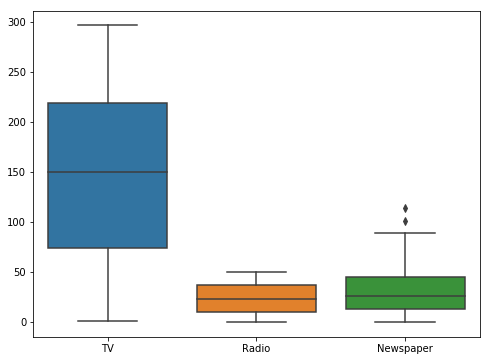

In [5]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data[["TV", "Radio", "Newspaper"]])
plt.show()

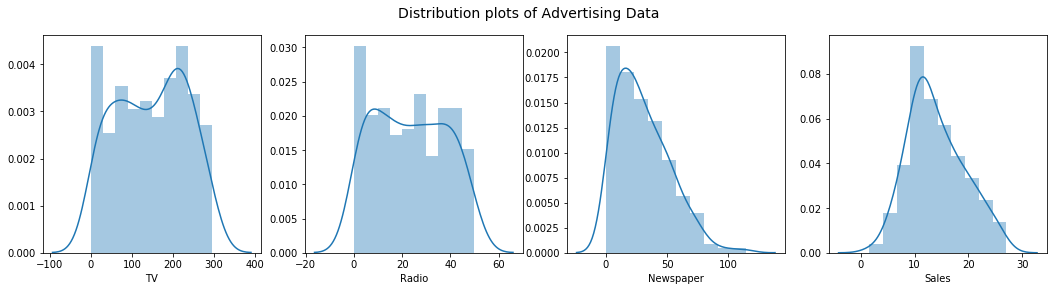

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(18,4))
sns.distplot(data.TV, ax=axs[0], bins=10)
sns.distplot(data.Radio, ax=axs[1], bins=10)
sns.distplot(data.Newspaper, ax=axs[2], bins=10)
sns.distplot(data.Sales, ax=axs[3], bins=10)
fig.suptitle("Distribution plots of Advertising Data", fontsize=14)
plt.show()

Use a **scatter plot** to visualize the relationship between the features and the response.

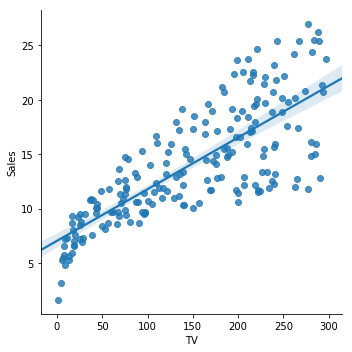

In [7]:
sns.lmplot("TV", "Sales", data)
plt.show()

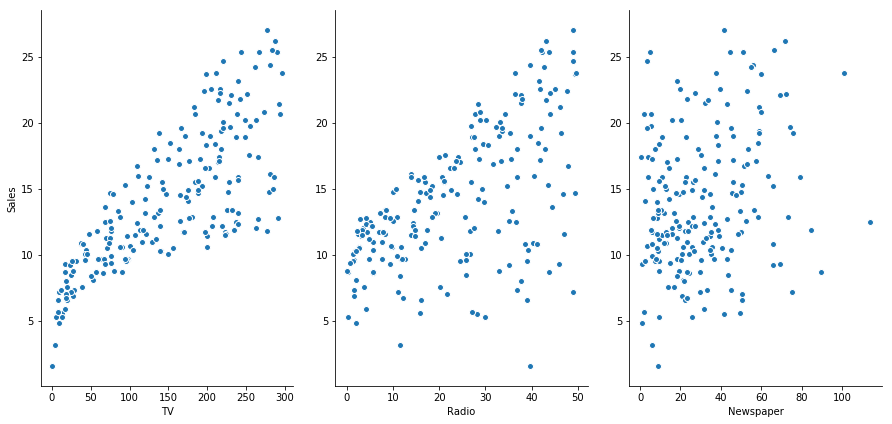

In [8]:
# scatter plot in Seaborn
sns.pairplot(data, x_vars=['TV','Radio','Newspaper'], y_vars='Sales', size=6, aspect=0.7)
plt.show()

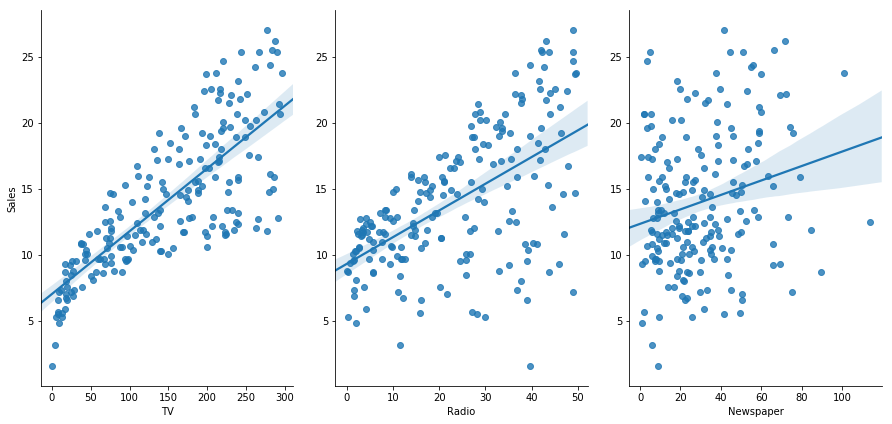

In [9]:
# include a "regression line"
sns.pairplot(data, x_vars=['TV','Radio','Newspaper'], y_vars='Sales', size=6, aspect=0.7, kind='reg')
plt.show()

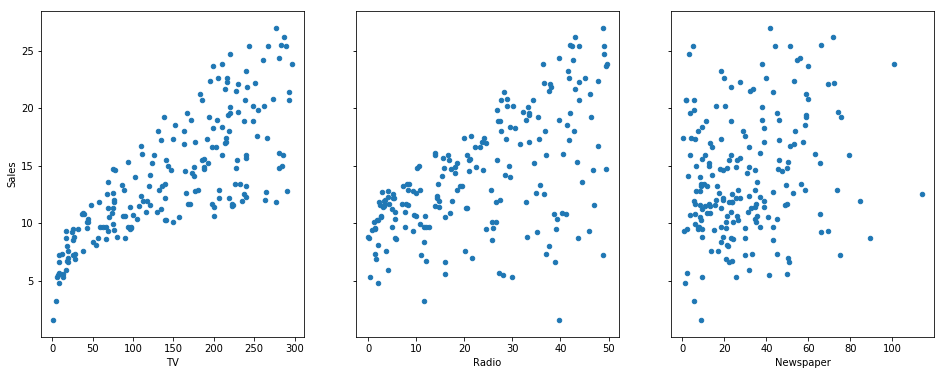

In [10]:
# scatter plot in Pandas
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0])
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])
plt.show()

Use a **scatter matrix** to visualize the relationship between all numerical variables.

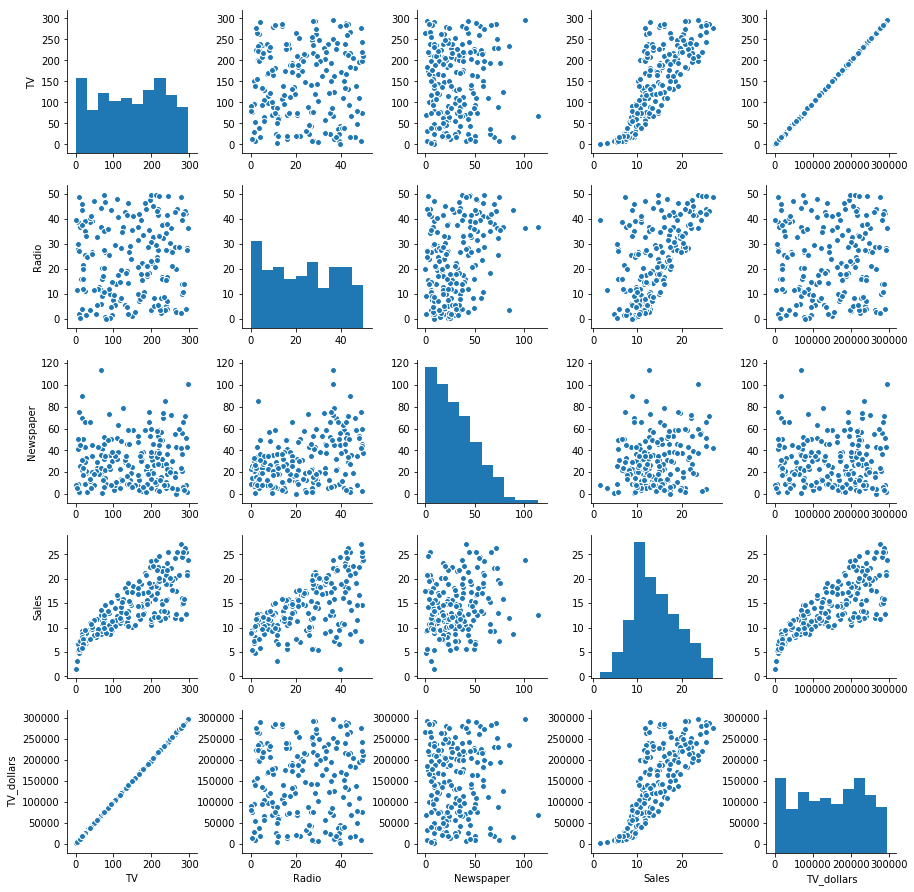

In [28]:
# scatter matrix in Seaborn
sns.pairplot(data)
plt.show()

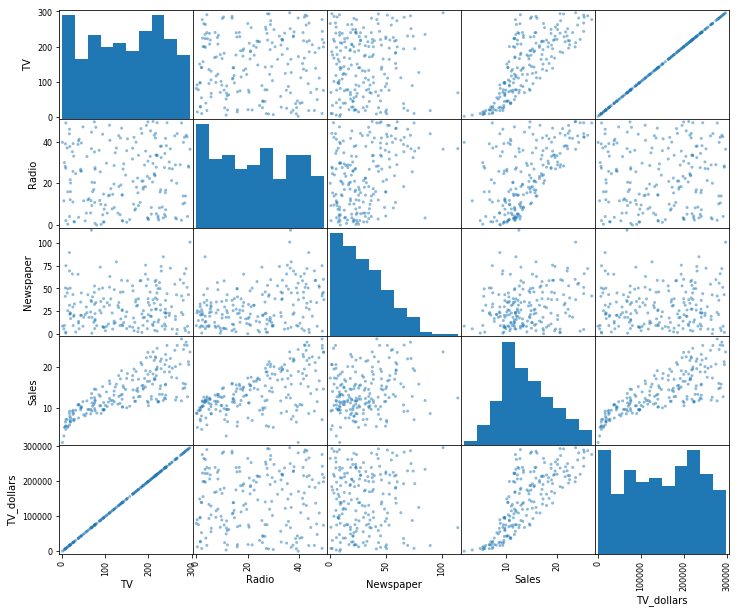

In [29]:
# scatter matrix in Pandas
pd.plotting.scatter_matrix(data, figsize=(12, 10))
plt.show()

Use a **correlation matrix** to visualize the correlation between all numerical variables.

In [30]:
# compute correlation matrix
data.corr()

,TV,Radio,Newspaper,Sales,TV_dollars
TV,1.000000,0.054809,0.056648,0.782224,1.000000
Radio,0.054809,1.000000,0.354104,0.576223,0.054809
Newspaper,0.056648,0.354104,1.000000,0.228299,0.056648
Sales,0.782224,0.576223,0.228299,1.000000,0.782224
TV_dollars,1.000000,0.054809,0.056648,0.782224,1.000000


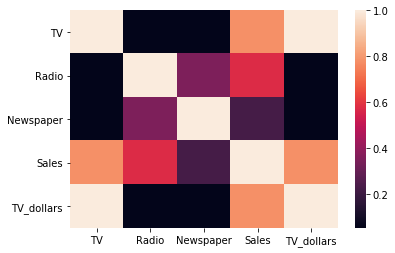

In [31]:
# display correlation matrix in Seaborn using a heatmap
sns.heatmap(data.corr())
plt.show()

You can choose the **color map** https://matplotlib.org/users/colormaps.html

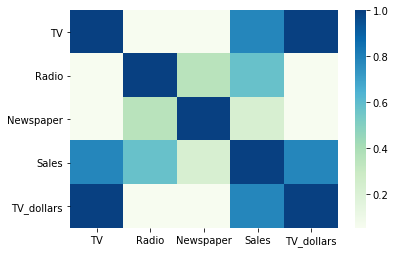

In [32]:
sns.heatmap(data.corr(), cmap="GnBu")
plt.show()

# Part 2: Simple linear regression

Simple linear regression is an approach for predicting a **continuous response** using a **single feature**. It takes the following form:

$y = \beta_0 + \beta_1x$

- $y$ is the response
- $x$ is the feature
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for x

$\beta_0$ and $\beta_1$ are called the **model coefficients**:

- We must "learn" the values of these coefficients to create our model.
- And once we've learned these coefficients, we can use the model to predict Sales.

## Estimating ("learning") model coefficients

- Coefficients are estimated during the model fitting process using the **least squares criterion**.
- We are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").

![Estimating coefficients](data/images/estimating_coefficients.png)

In this diagram:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the distances between the observed values and the least squares line.

![Slope-intercept](data/images/slope_intercept.png)

How do the model coefficients relate to the least squares line?

- $\beta_0$ is the **intercept** (the value of $y$ when $x$=0)
- $\beta_1$ is the **slope** (the change in $y$ divided by change in $x$)

Let's estimate the model coefficients for the advertising data:

In [33]:
# create X and y
feature_cols = ['TV']
X = data[feature_cols]
y = data.Sales

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

7.032593549127693
[0.04753664]


## Interpreting model coefficients

How do we interpret the TV coefficient ($\beta_1$)?

- A "unit" increase in TV ad spending is **associated with** a 0.0475 "unit" increase in Sales.
- Meaning: An additional $1,000 spent on TV ads is **associated with** an increase in sales of 47.5 widgets.
- This is not a statement of **causation**.

If an increase in TV ad spending was associated with a **decrease** in sales, $\beta_1$ would be **negative**.

## Using the model for prediction

Let's say that there was a new market where the TV advertising spend was **$50,000**. What would we predict for the Sales in that market?

$$y = \beta_0 + \beta_1x$$
$$y = 7.0326 + 0.0475 \times 50$$

In [17]:
# manually calculate the prediction
7.0326 + 0.0475*50

9.4076

In [18]:
X_new = pd.DataFrame({'TV': [50]})

# predict for a new observation
linreg.predict(X_new)

array([9.40942557])

Thus, we would predict Sales of **9,409 widgets** in that market.

## Does the scale of the features matter?

Let's say that TV was measured in dollars, rather than thousands of dollars. How would that affect the model?

In [19]:
data['TV_dollars'] = data.TV * 1000
data.head()

,TV,Radio,Newspaper,Sales,TV_dollars
1,230.1,37.8,69.2,22.1,230100.0
2,44.5,39.3,45.1,10.4,44500.0
3,17.2,45.9,69.3,9.3,17200.0
4,151.5,41.3,58.5,18.5,151500.0
5,180.8,10.8,58.4,12.9,180800.0


In [20]:
# create X and y
feature_cols = ['TV_dollars']
X = data[feature_cols]
y = data.Sales

linreg = LinearRegression().fit(X, y)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

7.032593549127694
[4.75366404e-05]


How do we interpret the TV_dollars coefficient ($\beta_1$)?

- A "unit" increase in TV ad spending is **associated with** a 0.0000475 "unit" increase in Sales.
- Meaning: An additional dollar spent on TV ads is **associated with** an increase in sales of 0.0475 widgets.
- Meaning: An additional $1,000 spent on TV ads is **associated with** an increase in sales of 47.5 widgets.

In [21]:
# predict for a new observation
linreg.predict(50000)

array([9.40942557])

The scale of the features is **irrelevant** for linear regression models, since it will only affect the scale of the coefficients, and we simply change our interpretation of the coefficients.

## How well does the model fit the data?

R-squared:

- A common way to evaluate the overall fit of a linear model
- Defined as the **proportion of variance explained**, meaning the proportion of variance in the observed data that is explained by the model
- Also defined as the reduction in error over the **null model**, which is the model that simply predicts the mean of the observed response
- Between 0 and 1, and higher is better

Here's an example of what R-squared "looks like":

![R-squared](data/images/r_squared.png)

Let's calculate the R-squared value for our simple linear model:

In [22]:
# calculate the R-squared value for the model
y_pred = linreg.predict(X)
metrics.r2_score(y, y_pred)

0.611875050850071

- The threshold for a **"good" R-squared value** is highly dependent on the particular domain.
- R-squared is more useful as a tool for **comparing models**.

# Part 3: Multiple Linear Regression

Simple linear regression can easily be extended to include multiple features, which is called **multiple linear regression**:

$y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$

Each $x$ represents a different feature, and each feature has its own coefficient:

$y = \beta_0 + \beta_1 \times TV + \beta_2 \times Radio + \beta_3 \times Newspaper$

In [23]:
# create X and y
feature_cols = ['TV', 'Radio', 'Newspaper']
X = data[feature_cols]
y = data.Sales

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

2.9388893694594085
[ 0.04576465  0.18853002 -0.00103749]


In [24]:
# pair the feature names with the coefficients
dict(zip(feature_cols, linreg.coef_))

{'Newspaper': -0.0010374930424763272,
 'Radio': 0.18853001691820456,
 'TV': 0.045764645455397615}

For a given amount of Radio and Newspaper spending, an increase of $1000 in **TV** spending is associated with an **increase in Sales of 45.8 widgets**.

For a given amount of TV and Newspaper spending, an increase of $1000 in **Radio** spending is associated with an **increase in Sales of 188.5 widgets**.

For a given amount of TV and Radio spending, an increase of $1000 in **Newspaper** spending is associated with an **decrease in Sales of 1.0 widgets**. How could that be?

### Preview: Validation set and RMSE

In [25]:
# define a function that accepts X and y and computes testing RMSE
def train_test_rmse(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [26]:
# include Newspaper
feature_cols = ['TV', 'Radio', 'Newspaper']
X = data[feature_cols]
train_test_rmse(X, y)

1.404651423032895

In [27]:
# exclude Newspaper
feature_cols = ['TV', 'Radio']
X = data[feature_cols]
train_test_rmse(X, y)

1.3879034699382886

## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Sensitive to irrelevant features
- Can't automatically learn feature interactions